In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile
from scipy.stats import pearsonr, zscore
from mne_bids import BIDSPath
from functools import partial
from nilearn.plotting import plot_markers

In [2]:
# PARAMS

bids_root = "/srv/nfs-data/sisko/storage/ECoG_podcast/ds005574-1.0.2" 



## ECoG Preprocessing

In [3]:
file_path_prep = BIDSPath(root=bids_root,
                    subject="02", task="podcast", datatype="ieeg",
                    suffix="ieeg", extension=".edf")
print(f"File path within the dataset: {file_path_prep}")

File path within the dataset: /srv/nfs-data/sisko/storage/ECoG_podcast/ds005574-1.0.2/sub-02/ieeg/sub-02_task-podcast_ieeg.edf


In [4]:
raw = mne.io.read_raw_edf(file_path_prep, verbose=False)

/tmp/ipykernel_1665254/455283776.py:1: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(file_path_prep, verbose=False)


In [5]:
def name2type(channel_name: str) -> str:
    if channel_name.startswith("DC"):
        return 'misc'
    elif channel_name == 'Pulse Rate':
        return 'misc'
    elif channel_name.startswith("EKG"):
        return 'ecg'
    else:
        return 'ecog'

channel_type_mapping = {name: name2type(name) for name in raw.ch_names}

raw = raw.set_channel_types(channel_type_mapping)
raw

/tmp/ipykernel_1665254/3856841931.py:13: RuntimeWarning: The unit for channel(s) DC1, DC10, DC11, DC12, DC2, DC3, DC4, DC5, DC6, DC7, DC8, DC9, Pulse Rate has changed from V to NA.
  raw = raw.set_channel_types(channel_type_mapping)


<RawEDF | sub-02_task-podcast_ieeg.edf, 113 x 921600 (1800.0 s), ~110 kB, data not loaded>

Effective window size : 4.000 (s)


/tmp/ipykernel_1665254/428485453.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


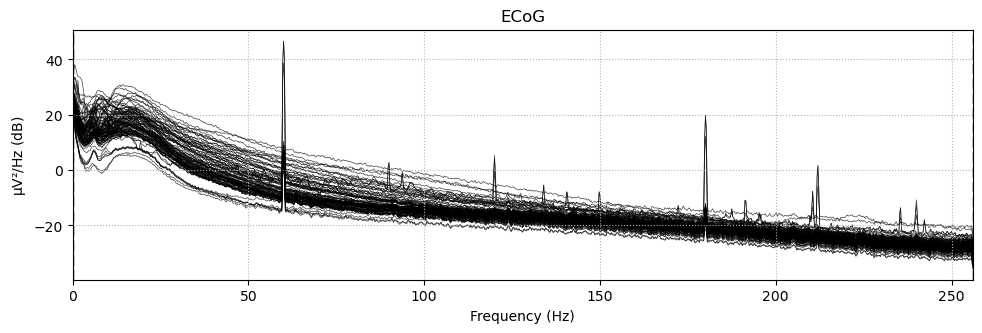

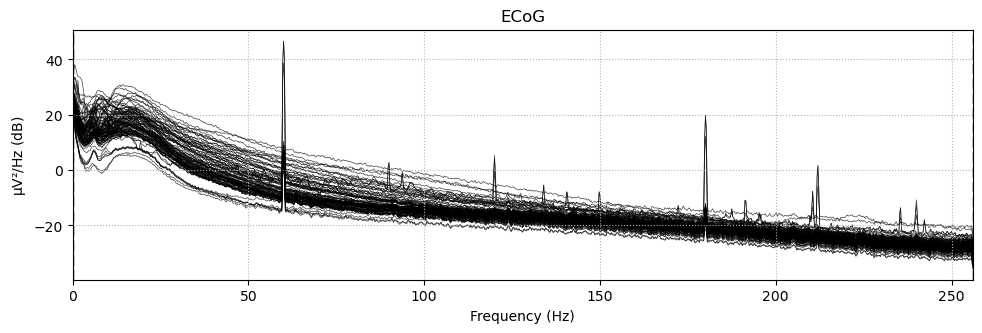

In [6]:
psd = raw.compute_psd(picks='ecog')
psd.plot()

In [7]:
# raw.info['bads'] = ['DAMT1', 'DPMT4', 'DPMT6', 'DPMT7']
# raw

In [8]:
# Re-reference data
raw.load_data() 
rereferenced_raw = raw.set_eeg_reference(ref_channels="average", ch_type="ecog")

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...
Applying average reference.
Applying a custom ('ECoG',) reference.


In [9]:
# Notch filter power line noise
powerline_freq = raw.info.get("line_freq")
if powerline_freq is None:
    powerline_freq = 60
freqs = [powerline_freq * m for m in range(1, 4)]
notched_raw = rereferenced_raw.notch_filter(freqs=freqs, notch_widths=2)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s


In [10]:
iir_params = dict(order=4, ftype="butter")
band_raw = notched_raw.filter(70, 200, picks="data", method="iir", iir_params=iir_params)
band_raw = band_raw.apply_hilbert(envelope=True)
band_raw

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 70 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 70.00, 200.00 Hz: -6.02, -6.02 dB



<RawEDF | sub-02_task-podcast_ieeg.edf, 113 x 921600 (1800.0 s), ~794.6 MB, data loaded>

In [11]:
band_raw.get_data().shape       # (124, 921600)

(113, 921600)

## Getting Started

In [12]:
file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject="03",
                     task="podcast",
                     datatype="ieeg",
                     description="highgamma",
                     suffix="ieeg",
                     extension="fif")
print(f"File path within the dataset: {file_path}")

File path within the dataset: /srv/nfs-data/sisko/storage/ECoG_podcast/ds005574-1.0.2/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif


/tmp/ipykernel_1665254/4289668959.py:1: FutureWarning: extension should start with a period ".", but got: "fif". Prepending "." to form: ".fif". This will raise an exception starting with MNE-BIDS 0.12.
  file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",


In [13]:
raw = mne.io.read_raw_fif(file_path, verbose=False)
raw

<Raw | sub-03_task-podcast_desc-highgamma_ieeg.fif, 235 x 921600 (1800.0 s), ~325 kB, data not loaded>

In [14]:
data = raw.get_data()
print(f"Data is a {type(data)} object and has a shape of: {data.shape}")    # num_channels x num_samples

Data is a <class 'numpy.ndarray'> object and has a shape of: (235, 921600)


In [15]:
print("First channel name is:", raw.info.ch_names[0])
print("Metadata associated with the first channel:")
raw.info['chs'][0]

First channel name is: LGA2
Metadata associated with the first channel:


{'scanno': 1,
 'logno': 2,
 'kind': 902 (FIFFV_ECOG_CH),
 'range': 1.0,
 'cal': 1.0,
 'coil_type': 1 (FIFFV_COIL_EEG),
 'loc': array([-0.054,  0.04 ,  0.023,  0.   ,  0.   ,  0.   ,    nan,    nan,
           nan,    nan,    nan,    nan]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'LGA2',
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

In [16]:
raw.info['chs'][0]['loc'][:3]    # x, y, z coordinates of the first channel

array([-0.054,  0.04 ,  0.023])

In [17]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

Coordinate matrix shape:  (235, 3)


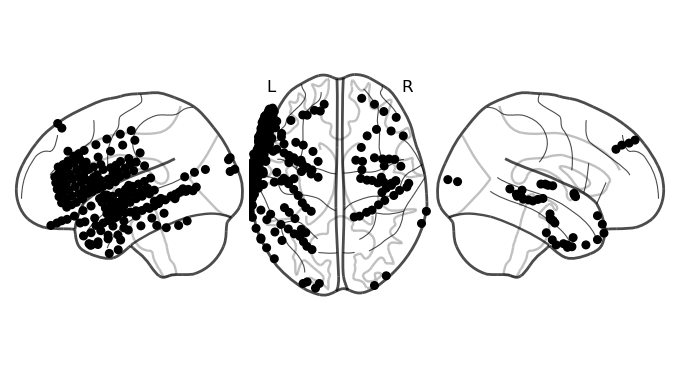

In [18]:
values = np.ones(len(coords))
fig = plot_markers(values, coords,
             node_size=30, display_mode='lzr', alpha=1,
             node_cmap='Greys', colorbar=False, node_vmin=0, node_vmax=1)
print(fig)

## Event Related Potential

In [19]:
raw = mne.io.read_raw_fif(file_path, verbose=False)
# picks = mne.pick_channels_regexp(raw.ch_names, "LG[AB]*")
# raw = raw.pick(picks)
raw

<Raw | sub-03_task-podcast_desc-highgamma_ieeg.fif, 235 x 921600 (1800.0 s), ~325 kB, data not loaded>

In [20]:
ecog_data = raw.get_data()
print(f"ECoG data has a shape of: {ecog_data.shape}")

ECoG data has a shape of: (235, 921600)


In [132]:
audio_path = f"{bids_root}/stimuli/podcast.wav"
audio_sf, audio_wave = wavfile.read(audio_path)

print(f"Audio waveform is sampled at {audio_sf} Hz and has a shape of: {audio_wave.shape}")

# We will arbitrarily select the first channel from the stereo audio
if audio_wave.ndim > 1:
    audio_wave = audio_wave.mean(axis=1)

/tmp/ipykernel_1665254/1027556665.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


Audio waveform is sampled at 44100 Hz and has a shape of: (79380000, 2)


In [133]:
from IPython.display import Audio
Audio(audio_wave[:audio_sf*30], rate=audio_sf)

In [134]:
def preprocess_raw_audio(x, fs, to_fs, lowcut=200, highcut=5000):

    # See https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype="band")
        return b, a

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.lfilter(b, a, data)
        return y

    assert x.ndim == 1

    # Step 1. Bandpass the high quality audio
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

    # Step 2. Downsample to same freq as clinical system
    # Number of new samples is N = n * (to_fs / fs)
    # y = signal.resample(y, num=round(x.size / fs * to_fs))

    # Step 3. Take audio envelope
    envelope = np.abs(signal.hilbert(y - y.mean()))

    return envelope

In [135]:
ecog_sr = raw.info['sfreq']
audio_power = preprocess_raw_audio(audio_wave, audio_sf, ecog_sr)

print(f"Audio power is sampled at {ecog_sr} Hz and has a shape of: {audio_power.shape}. ECoG data is {ecog_data.shape}.")

Audio power is sampled at 512.0 Hz and has a shape of: (79380000,). ECoG data is (235, 921600).


In [136]:
transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"

df = pd.read_csv(transcript_path)
df.dropna(subset=['start'], inplace=True)
df.sort_values("start", inplace=True)
df.head(10)

,word,start,end
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111
5,middle.,5.151,5.391
6,So,6.592,6.732
7,there's,6.752,6.912
8,some,6.892,7.052
9,places,7.072,7.342


In [137]:
events = np.zeros((len(df), 3))
events[:, 0] = df.start
print(f"events array has a shape of: {events.shape}")   # events = onset of the word

events array has a shape of: (5136, 3)


In [138]:
events

array([[   3.71 ,    0.   ,    0.   ],
       [   3.99 ,    0.   ,    0.   ],
       [   4.651,    0.   ,    0.   ],
       ...,
       [1798.786,    0.   ,    0.   ],
       [1799.046,    0.   ,    0.   ],
       [1799.327,    0.   ,    0.   ]])

In [139]:
# zscore the electrode time series so they're all on the same scale
func = partial(zscore, axis=1)
raw.load_data()
raw = raw.apply_function(func, channel_wise=False)

epochs = mne.Epochs(
    raw,
    (events * raw.info['sfreq']).astype(int),
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
    proj=None,
    event_id=None,
    preload=True,
    event_repeated="merge",
)

print(f"Epochs object has a shape of: {epochs._data.shape}")

Not setting metadata
5136 matching events found
No baseline correction applied
Using data from preloaded Raw for 5136 events and 1025 original time points ...
5 bad epochs dropped
Epochs object has a shape of: (5131, 235, 1025)


In [140]:
# 921600 tp / 1025 tp = 900 circa, ovvero 1799.998 secs / 2 secs
# quindi ogni parola ha 1025 tp di attività (2 secondi)

## Extract Audio Onset Embedding

In [141]:
import torch
from torch import nn
import torchaudio
from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, WhisperFeatureExtractor, WhisperForConditionalGeneration, AutoProcessor


In [142]:
model = WhisperModel.from_pretrained("openai/whisper-base")
feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
# processor = WhisperProcessor.from_pretrained("openai/whisper-base")
# feature_extractor_w = WhisperFeatureExtractor(chunk_length=2)
# tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base")

# T = 100
# model.encoder.embed_positions = nn.Embedding(T, 512)

processor = AutoProcessor.from_pretrained("openai/whisper-base")
model_gen = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
model_gen.config.forced_decoder_ids = None
model_gen.eval()

/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (fin

In [143]:
# with torch.no_grad():
#     outputs = model.encoder(**inputs_proc)
#     hidden_states = outputs.last_hidden_state  

# print("Feature shape:", hidden_states.shape)

In [144]:
audio_wave = audio_wave.astype(np.float32)
audio_wave_good = audio_wave / np.max(np.abs(audio_wave))

In [218]:
count = 0
for idx, row in df.iterrows():
    print("Target word:", row["word"])
    start_sample = int((row['start']) * audio_sf) 
    end_sample = start_sample + int(1.5 * audio_sf)
    snippet = audio_wave_good[start_sample - int(0.2 * audio_sf):end_sample]
    snippet = torchaudio.transforms.Resample(audio_sf, 16000)(torch.tensor(snippet).float())
    inputs = processor(snippet.squeeze(0), sampling_rate=16000, return_tensors="pt")
    # inputs = feature_extractor_w(snippet.squeeze(0), sampling_rate=16000, return_tensors="pt")
    input_features = inputs['input_features']
    with torch.no_grad():
        outputs = model_gen.model.encoder(input_features=input_features)
        print("Output shape:", outputs.last_hidden_state.shape)
        # mask = torch.ones_like(outputs.last_hidden_state)  # [1, 1500, 512]
        # mask[:, 200:-1, :] = 0  
        # masked_hidden_states = outputs.last_hidden_state * mask
        # outputs.last_hidden_state = masked_hidden_states
        
        outputs.last_hidden_state = outputs.last_hidden_state[:,:200]    
        outputs.last_hidden_state = outputs.last_hidden_state[:,::2]
        print("Output shape after:", outputs.last_hidden_state.shape)

        generated_ids = model_gen.generate(
            encoder_outputs=outputs
        )
    transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print("Decoded:", transcription)
    if idx == 15:
        break
    

Target word: Act
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded:  At Guan Monkey in the middle
Target word: one,
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded:  Guan Manquilla in the middle.
Target word: monkey
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded:  Monkey in the middle
Target word: in
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded:  in the middle.
Target word: the
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded: <|0.00|> in the middle.<|0.64|>
Target word: middle.
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded:  in the middle.
Target word: So
Output shape: torch.Size([1, 1500, 512])
Output shape after: torch.Size([1, 100, 512])
Decoded:  So there are some places where animals almost live.
Tar